# Candlestick Charts in Finance

| Key              | Value                                                                                                                                                                                                                                                                                                            |
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                                                                                                                                                                                            |
| **Course Names** | BBT 4206: Business Intelligence II (Week 7-9 of 13)<br>BFS 4102: Advanced Business Data Analytics (Week 7-9 of 13)                                                                                                                                                                                               |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                                          |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                                     |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                                           |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/RecommendedCitation.bib) |

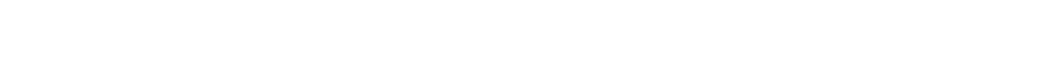

- A candlestick chart is used to describe price movements of a security, derivative, or currency. Each "candlestick" typically shows one day, thus a one-month chart may show 20 trading days as 20 candlesticks. Candlestick charts are most often used in technical analysis of equity and currency price patterns.
- It is similar in appearance to a bar chart, but the color and shape of the candlestick provide more visual information about how the price moved during the day.
- The "body" of the candlestick represents the range between the opening and closing prices of that day. If the body is filled or colored green/black, it means the closing price was lower than the opening price (a bearish signal). If the body is empty or colored red, it means the closing price was higher than the opening price (a bullish signal).
- The "wick" or "shadow" represents the highest and lowest prices of the day. The top of the wick indicates the highest price, while the bottom of the wick indicates the lowest price.
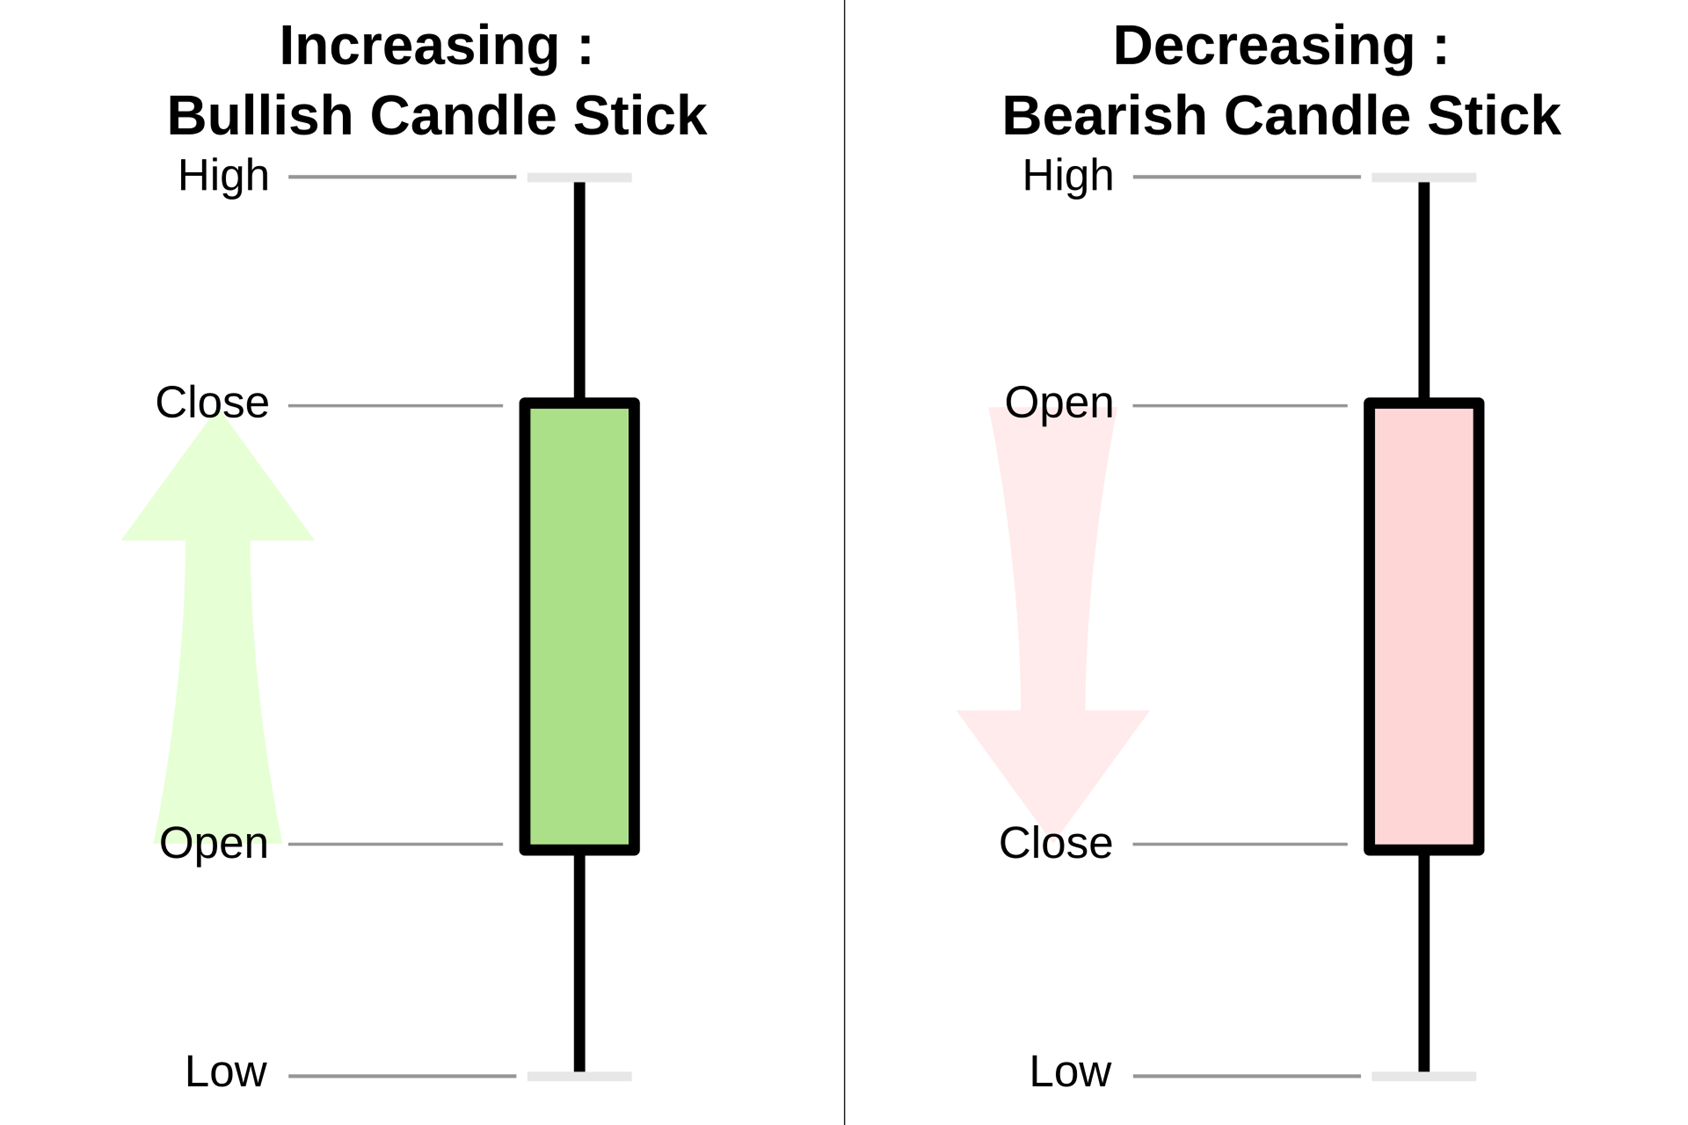

## Step 1: Import the necessary libraries

**Purpose**: This chunk imports all the necessary libraries for data analysis, machine learning, and visualization.

1. **For File and system operations [urllib3](https://urllib3.readthedocs.io/en/stable/)**
    - `urllib.request` is used for opening and downloading data from URLs.
    - `from pathlib import Path` is used to handle file paths in a platform-independent way.
    - `os` provides functions for interacting with the operating system, such as file and directory management.

2. **For data manipulation - [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html):**
    - `pandas as pd`: For loading the dataset, creating and managing DataFrames, data manipulation and analysis using DataFrames

3. **For data preprocessing and transformation - [mlxtend](https://rasbt.github.io/mlxtend/)**
    - `TransactionEncoder`: Converts transaction data into a binary matrix format

4. **For association rule learning - [mlxtend](https://rasbt.github.io/mlxtend/)**
    - `apriori`: Implements the Apriori algorithm for finding frequent itemsets
    - `association_rules`: Generates rules from frequent itemsets

5. **For data visualization - [matplotlib](https://matplotlib.org/stable/gallery/index.html) and [seaborn](https://seaborn.pydata.org/examples/index.html)**
    - `matplotlib.pyplot as plt`: For basic plotting functionality
    - `seaborn as sns`: For enhanced statistical visualizations

6. **For suppressing warnings - [warnings](https://docs.python.org/3/library/warnings.html)**
    - `warnings`: Controls warning messages
    - `warnings.filterwarnings('ignore')`: Suppresses warning messages for cleaner output
    - Used to suppress warnings that may arise during the execution of the code. Even though it is not necessary for the code to run, it helps in keeping the output clean and focused on the results.

In [ ]:
# For file and system operations
import urllib.request
from pathlib import Path
import os

# For data manipulation
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import re

# For data visualization
import matplotlib.pyplot as plt

import mplfinance as mpf
import yfinance as yf

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Ensures that matplotlib plots are displayed directly within the notebook,
# right below the code cell that produces them. It makes visualizations appear
# inline for easier viewing and analysis.
%matplotlib inline

## Step 2: Load the Data

### Option 1 (Download of Stock Prices via the Yahoo Finance API)

- The following site (amongst many others) lists available stock symbols: https://stockanalysis.com/stocks/
- Some are available via Yahoo Finance and others are not.

In [ ]:
start = "2024-01-01"
end = dt.datetime.now().strftime("%Y-%m-%d")

data = yf.download("NVDA", start=start, end=end)
data.columns = [col[0] for col in data.columns]  # Flatten MultiIndex to single names

### Option 2 (Manual Download of Stock Prices)

In [ ]:
# # Manual download link:
# # https://www.marketwatch.com/investing/stock/scom/download-data?countrycode=ke
# file = './data/Download Data - STOCK_KE_XNAI_SCOM.csv'
# data = pd.read_csv(file)

In [ ]:
# dataset_path = './data/Download Data - STOCK_KE_XNAI_SCOM.csv'
# # Manual download link:
# # https://www.marketwatch.com/investing/stock/scom/download-data?countrycode=ke
#
# if not os.path.exists(dataset_path):
#     print("❌ Please download the dataset manually first.")
# else:
#     print("✅ Dataset exists locally")
#
# data = pd.read_csv(dataset_path, encoding='utf-8', nrows=200000)

## Step 3: Confirm the Loaded Data

In [ ]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())

In [ ]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())

## Step 4: Save the Original Data

In [ ]:
# Save the results as a CSV file for further analysis and reporting
output_path = './data/stockprice_original.csv'
# Ensure the data directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')
# Save the CSV file regardless of environment (Google Colab or local)
data.to_csv(output_path, index=True)
print(f"\n✅ Results saved to {output_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped dataset download link.")


## Step 5: Data Cleaning and Preparation

In [ ]:
# 1) Ensure datetime index and sorted

# This line converts the `Date` column in the `data` DataFrame to datetime
# objects. The `errors="coerce"` argument means that any value that cannot
# be parsed as a date will be replaced with `NaT` (Not a Time), which is
# pandas' way of marking missing or invalid dates. This helps prevent errors
# from invalid date formats and ensures the column is consistently typed.
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
    data = data.set_index("Date")

data = data.sort_index()

# 2) Normalize column names (trim, unify, and fix common naming)
data.columns = [c.strip() for c in data.columns]
rename_map = {
    "Close/Last": "Close",
    "Adj Close": "Close",
    "Adj. Close": "Close",
    "Closing Price": "Close",
    "Open Price": "Open",
    "Opening Price": "Open",
    "High Price": "High",
    "Low Price": "Low",
    "Trade Volume": "Volume",
    "Volume (Shares)": "Volume",
    "Total Volume": "Volume",
    "High/Low": "High",
    "Low/High": "Low"
}
data = data.rename(columns=rename_map)

# 3) Define a helper to strip non-numeric characters (keep digits, dot, minus)
def to_numeric_str(s: str) -> str:
    # Handle None/NaN safely
    s = "" if s is None else str(s)
    # Strip any characters except digits, decimal point, minus
    return re.sub(r"[^0-9.\-]", "", s)

# 4) Coerce OHLC to float
ohlc_cols = [c for c in ["Open", "High", "Low", "Close"] if c in data.columns]
for c in ohlc_cols:
    data[c] = pd.to_numeric(data[c].astype(str).map(to_numeric_str), errors="coerce")

# 5) Coerce Volume to numeric (basic version: strip non-numeric)
if "Volume" in data.columns:
    data["Volume"] = pd.to_numeric(data["Volume"].astype(str).map(to_numeric_str), errors="coerce")

# Optional: if your Volume has K/M/B suffixes (e.g., 12K, 3.5M, 1.2B) and you want correct scaling:
def parse_volume(v):
    v = str(v).strip()
    if not v or v.lower() == "nan":
        return float("nan")
    mult = 1
    if v[-1] in "KkMmBb":
        suffix = v[-1].upper()
        v = to_numeric_str(v[:-1])
        mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}[suffix]
    else:
        v = to_numeric_str(v)
    return float(v) * mult if v else float("nan")
if "Volume" in data.columns:
    data["Volume"] = data["Volume"].map(parse_volume)

# 6) Drop rows where any of OHLC are missing (mplfinance needs valid OHLC rows)
if ohlc_cols:
    data = data.dropna(subset=ohlc_cols)

## Step 6: Confirm Cleaned Data

In [ ]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())

In [ ]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(data["Open"])
plt.show()

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(data["Close"])
plt.show()

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(data["Volume"])
plt.show()

In [ ]:
mpf.plot(data, type="candle", style="yahoo", volume=("Volume" in data.columns))

In [ ]:
mpf.plot(data, type="candle", style="yahoo", volume=True)

In [ ]:
mpf.plot(data, type="candle", style="yahoo", volume=False)

## Step 7: Save the Cleaned Data

In [ ]:
# Save the results as a CSV file for further analysis and reporting
output_path = './data/stockprice_cleaned.csv'
# Ensure the data directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')
# Save the CSV file regardless of environment (Google Colab or local)
data.to_csv(output_path, index=True)
print(f"\n✅ Results saved to {output_path}")

# Provide a download link if running in Google Colab
try:
    from google.colab import files
    files.download(output_path)
except ImportError:
    print("❌ Not running in Google Colab, skipped dataset download link.")

## Step 8: Drill down to a Specific Month Range and Plot Candlestick Chart

In [ ]:
# Ensure datetime index
data.index = pd.to_datetime(data.index)

# Define a range of months
start_month = "2025-07"
end_month   = "2025-09"

try:
    # Use .loc to slice safely using a date range
    month_df = data.loc[start_month:end_month]
except KeyError:
    raise ValueError(
        f"No data available from {start_month} to {end_month}. "
        f"Available range: {data.index.min().date()} to {data.index.max().date()}"
    )

# Check if DataFrame is empty
if month_df.empty:
    raise ValueError(
        f"No data available from {start_month} to {end_month}. "
        f"Available range: {data.index.min().date()} to {data.index.max().date()}"
    )
else:
    # Plot candlestick with volume disabled
    mpf.plot(month_df, type="candle", style="yahoo", volume=False)

In [ ]:
mpf.plot(month_df, type="candle", style="yahoo", volume=True)

## Step 9: Customize a Candlestick Chart

- Add a title and make the figure bigger.

In [ ]:
mpf.plot(month_df, type='candle',
         volume=True, tight_layout=False,
         style="yahoo",
         figratio=(25,10),
         title = 'NVIDIA Daily OHLC Prices - 2025Q3')

Explore additional styles.

In [ ]:
print(mpf.available_styles())

In [ ]:
mpf.plot(month_df, type="candle", style="classic", volume=True)

- Add your own customer colours

In [ ]:
colors = mpf.make_marketcolors(up="green", down="red", edge="inherit", wick="inherit", volume="in")
custom_mpf_style = mpf.make_mpf_style(base_mpf_style="classic", marketcolors=colors)

## Step 10: Add Short, Medium, and Long-Term Moving Averages

- 5-Period MA (Short-Term): This average uses only the last 5 data points. It is responsive and reacts quickly to recent price fluctuations. You can use this to spot very recent shifts in momentum.
- 10-Period MA (Medium-Term): This uses the last 10 data points. It is smoother than the 5-period MA because it is less affected by a single day’s volatility. This MA is good for identifying a sustained, but not long-term, trend.
- 20-Period MA (Long-Term): This is the smoothest of the three, using the last 20 data points. It is the least responsive to short-term changes, acting as a reliable indicator of the major underlying trend.

- **Bullish Crossover**: When a shorter-term MA crosses above a longer-term MA, it is often interpreted as a bullish signal, suggesting that a new upward trend is forming.

- **Bearish Crossover**: Conversely, when a shorter-term MA crosses below a longer-term MA, it can be interpreted as a bearish signal, indicating a potential downward trend.
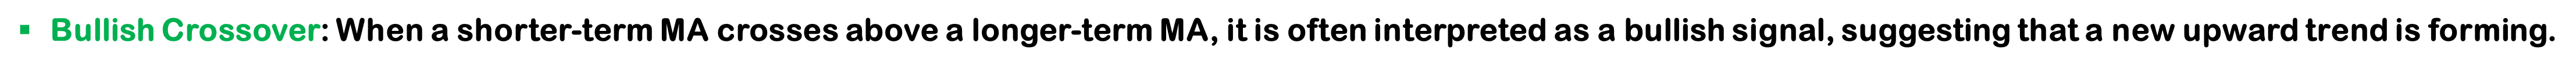

In [ ]:
mpf.plot(
    data,
    type='candle',
    mav=(5, 10, 20),
    mavcolors=['blue', 'orange', 'purple'],
    volume=True,
    tight_layout=True,
    figratio=(25, 10),
    title='NVIDIA Stock Price 2024Q1-2025Q3',
    style=custom_mpf_style
)

In [ ]:
mpf.plot(
    month_df,
    type='candle',
    mav=(5, 10, 20),
    mavcolors=['blue', 'orange', 'purple'],
    volume=True,
    tight_layout=True,
    figratio=(25, 10),
    title='NVIDIA Daily OHLC Prices - 2025Q3',
    style=custom_mpf_style
)